# RL and Advanced DL: Домашнее задание 2

Второе домашнее задание опять посвящено игре; его базовая часть, надеюсь, не слишком большая, но я добавил опциональную часть, которая, думаю, должна быть достаточно интересной для любого слушателя. Как обычно, **в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии**. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.  
![alt text](hw2_pic.png "Title")

In [1]:
import numpy as np
import random
from collections import defaultdict
from collections.abc import Iterable
from tic_tac_toe import TicTacToe, plot_test_game
import tqdm
import copy
import matplotlib.pyplot as plt

## Часть первая: крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.
1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.
**Disclaimer**: начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

In [2]:
env = TicTacToe(n_rows=4, n_cols=4, n_win=3)
# plot_test_game(env, None, None, random_crosses=True, random_naughts=True, verbose=True, fontx=60)

Создадим классы для случайной и eps-жадной политик

In [3]:
class RandomPolicy:
    def __init__(self):
        pass
    
    def get_action(self, state):
        _, empty_spaces, _ = state
        action_idx = np.random.randint(len(empty_spaces))
        return action_idx

In [4]:
class EpsGreedyPolicy:
    def __init__(self, eps=0.):
        self.Q = {}
        self.eps = eps

    def get_action(self, state):
        board_hash, empty_spaces, _ = state

        if random.random() >= self.eps and board_hash in self.Q:
            return np.argmax(self.Q[board_hash])
        
        if board_hash not in self.Q:
            self.Q[board_hash] = np.zeros(len(empty_spaces))
        
        return np.random.randint(len(empty_spaces))

Функция играющая один эпизод

In [5]:
def run_episode(env, policies: dict):
    env.reset()
    state = env.getState()
    _, empty_spaces, curr_turn = state
    # states, rewards, actions = [], [], []
    done = False
    
    while not done:
        action_idx = policies[curr_turn].get_action(state)
        action = empty_spaces[action_idx]
        # states.append(observation)
        # actions.append(action)
        state, reward, done, _ = env.step(action)
        _, empty_spaces, curr_turn = state
        # rewards.append(reward)

    return reward

Средняя награда за epoch эпизодов

In [6]:
def avg_reward(env, policies: dict, epochs=1000, verbose=True):
    crosses_wins = 0
    naughts_wins = 0
    draws = 0
    cnt = 0
    for _ in tqdm.tqdm(range(epochs), disable=not verbose):
        cnt += 1
        reward = run_episode(env, policies)
        if reward == 1:
            crosses_wins += 1
        elif reward == -1:
            naughts_wins += 1
        else:
            draws += 1 

    return crosses_wins / cnt, naughts_wins / cnt, draws / cnt

Самая простая реализация Q-learning для игр с противником:
1. Считаем действия и ходы противника частью среды
2. Если обучаем нолики, то домножаем награду на -1 (вместо этого можно было еще max(Q) заменить на min)

In [7]:
def Q_learning_episode(env, policies: dict, alpha=0.1, gamma=0.9, train_first_policy=True):
    done = False
    env.reset()
    state = env.getState()
    board_hash, empty_spaces, curr_turn = state
    side = 1
    
    # if we want to train naughts
    if not train_first_policy:
        action_idx = policies[curr_turn].get_action(state)
        action = empty_spaces[action_idx]
        state, reward, done, _ = env.step(action)
        board_hash, empty_spaces, curr_turn = state
        # reverse reward
        side = -1
    
    while not done:
        action_idx = policies[curr_turn].get_action(state)
        action = empty_spaces[action_idx]
        state_prime, reward, done, _ = env.step(action)
        reward *= side
        if not done:
            # enemy action
            _, enemy_empty_spaces, enemy_curr_turn = state_prime
            enemy_action_idx = policies[enemy_curr_turn].get_action(state_prime)
            action = enemy_empty_spaces[enemy_action_idx]
            state_prime, reward, done, _ = env.step(action)
            reward *= side
            
        board_hash_prime, _, _ = state_prime
        
        max_next_Q = (
            np.max(policies[curr_turn].Q[board_hash_prime])
            if board_hash_prime in policies[curr_turn].Q
            else 0.
        )
        
        policies[curr_turn].Q[board_hash][action_idx] += alpha * (
            reward + gamma * max_next_Q
            - policies[curr_turn].Q[board_hash][action_idx]
        )
        
        state = state_prime
        board_hash, empty_spaces, curr_turn = state
        

    return policies

In [8]:
%%timeit
bool(random.getrandbits(1))

146 ns ± 2.94 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [9]:
%%timeit
random.choice([True, False])

448 ns ± 11.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


Будем случайным образом обучать то одну стратегию, то другую  
Валидировать обе стратегии будем на случайной стратегии

In [17]:
def Q_learning(
    env, policies: dict, eval_policy=RandomPolicy(), 
    alpha=0.05, gamma=0.9,
    eps_init=0.9, eps_final=0.01, 
    eps_decay=2_000, evaluate_every=1_000,
    avg_reward_epochs=1000,
    epochs=20000, verbose=True
):
    
    crosses_history = {
        "crosses_win_rate": [],
        "noughts_win_rate": [],
        "draws_win_rate": [],
        "iteration": []
    }
    
    noughts_history = copy.deepcopy(crosses_history)
    
    for n in tqdm.tqdm(range(epochs), disable=not verbose):
        
        eps = eps_init + (eps_final - eps_init) * n / eps_decay
        for key in policies:
            policies[key].eps = eps
        
        # randomly choose policy for Q-learning
        train_first_policy = bool(random.getrandbits(1))
        policies = Q_learning_episode(
            env, policies, alpha=alpha, gamma=gamma,
            train_first_policy=train_first_policy
        )
        
        if n % evaluate_every == 0:
            
            crosses, noughts, draws = avg_reward(
                env, {1: policies[1], -1: eval_policy}, 
                epochs=avg_reward_epochs, verbose=verbose
            )
            crosses_history["crosses_win_rate"].append(crosses)
            crosses_history["noughts_win_rate"].append(noughts)
            crosses_history["draws_win_rate"].append(draws)
            crosses_history["iteration"].append(n)
            
            crosses, noughts, draws = avg_reward(
                env, {-1: policies[-1], 1: eval_policy},
                epochs=avg_reward_epochs, verbose=verbose
            )
            noughts_history["crosses_win_rate"].append(crosses)
            noughts_history["noughts_win_rate"].append(noughts)
            noughts_history["draws_win_rate"].append(draws)
            noughts_history["iteration"].append(n)

    return policies, crosses_history, noughts_history

In [18]:
def plot_history(history, fontsize: int = 16, figsize: tuple = (12, 6)):
    plt.figure(figsize=figsize)
    plt.title("Average winrate", fontsize=fontsize)
    plt.xlabel("Q-learning iteration", fontsize=fontsize)
    plt.ylabel("Average winrate", fontsize=fontsize)
    plt.plot(history["iteration"], history["crosses_win_rate"], label="Crosses")
    plt.plot(history["iteration"], history["noughts_win_rate"], label="Noughts")
    plt.plot(history["iteration"], history["draws_win_rate"], label="Draws")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

### Обучите стратегии крестиков и ноликов для доски 3х3.

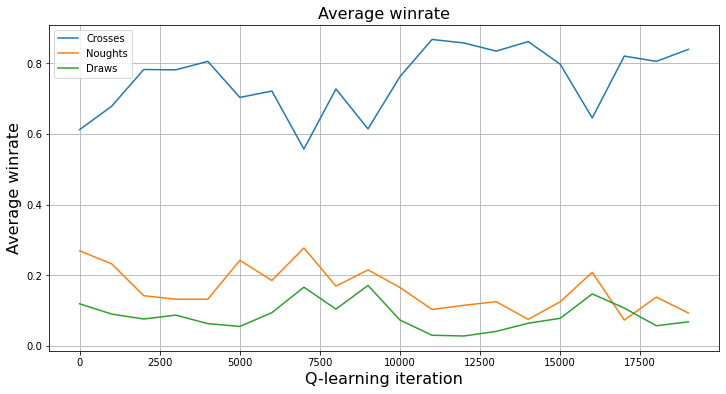

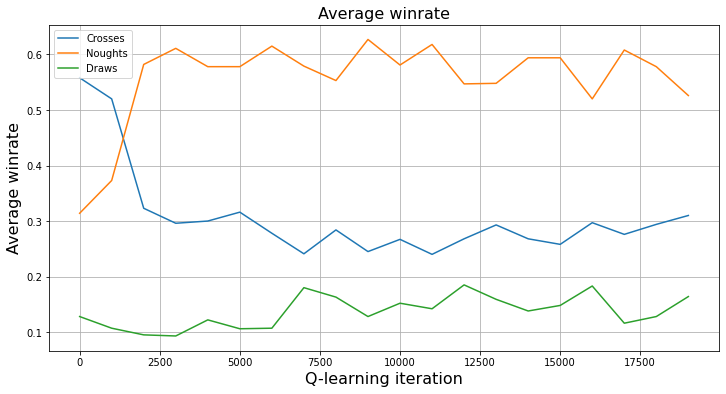

In [19]:
env = TicTacToe(n_rows=3, n_cols=3, n_win=3)

policies = {1: EpsGreedyPolicy(eps=.1), -1: EpsGreedyPolicy(eps=.1)}

policies, crosses_history, noughts_history = Q_learning(env, policies, verbose=False)

plot_history(crosses_history)
plot_history(noughts_history)

### Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.

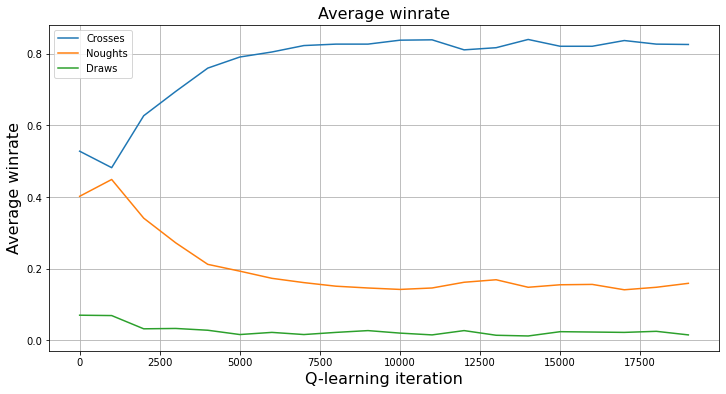

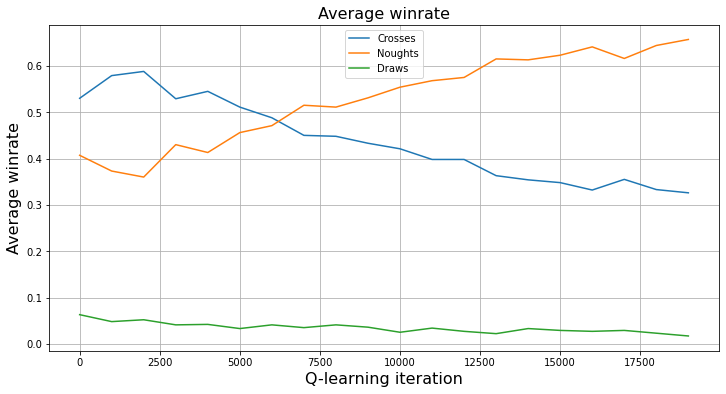

In [13]:
env = TicTacToe(n_rows=5, n_cols=5, n_win=4)

policies = {1: EpsGreedyPolicy(eps=.1), -1: EpsGreedyPolicy(eps=.1)}

policies, crosses_history, noughts_history = Q_learning(env, policies, verbose=False)

plot_history(crosses_history)
plot_history(noughts_history)

## Часть вторая: добавим нейронных сетей
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).  
1. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.
2. Реализуйте Double DQN и/или Dueling DQN.


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T
from torch.autograd import Variable

from tic_tac_toe import TicTacToe
import tqdm
import numpy as np
import random

import matplotlib.pyplot as plt

from collections import deque
import copy

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


/home/alexander/miniconda3/envs/rl/lib/python3.9/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068185/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


In [3]:
class ReplayMemory:
    def __init__(self, capacity: int):
        self.memory = deque([], maxlen=capacity)

    def store(self, transition):
        """Save a transition"""
        self.memory.append(transition)

    def sample(self, batch_size: int = 64):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [4]:
class Agent:
    def __init__(self, model: nn.Module, lr:float = 1e-5, memory_capacity:int = 30000):
        self.state = None
        self.action = None
        self.reward = None
        self.new_state = None
        self.model = model
        self.optimizer = optim.Adam(self.model.parameters(), lr)
        self.memory = ReplayMemory(capacity=memory_capacity)
        
    def update(self, new_state, action, reward, done):        
        new_state = np.stack(
            [
                (new_state == 1).astype(float),
                 (new_state == -1).astype(float),
                 (new_state == 0).astype(float)
            ]
        )
        if self.state is not None:
            self.memory.store((self.state, new_state, self.action, reward, done))
        self.state = new_state
        self.action = action   
        
    def reset(self):
        self.state = None
        self.action = None 
        
    def action_from_model(self, state):
        self.model.eval()
        state = np.stack(
            [
                (state == 1).astype(float),
                (state == -1).astype(float),
                (state == 0).astype(float)
            ]
        )
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        action = self.model(state).detach().max(1).indices.item()
        return action  
    
    def train_batch(self, batch_size=128, gamma=1):    
        if len(self.memory) < batch_size:
            return
        transitions = self.memory.sample(batch_size)
        states, next_states, actions, rewards, dones = list(zip(*transitions))

        batch_state = torch.FloatTensor(states).to(device)
        batch_next_state = torch.FloatTensor(next_states).to(device)
        batch_actions = torch.LongTensor(actions).to(device)
        batch_reward = torch.FloatTensor(rewards).to(device)
        batch_dones = torch.BoolTensor(rewards).to(device)

        self.model.train()
        Q = self.model(batch_state).gather(1, batch_actions.view(-1, 1)).flatten()

        #with torch.no_grad():
        Qmax = self.model(batch_next_state).detach().max(dim=1)[0]
        Qmax[batch_dones] = 0
        Qnext = batch_reward + gamma * Qmax

        loss = F.l1_loss(Q, Qnext)#F.smooth_l1_loss(Q, Qnext)    
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss.item()


In [5]:
class RandomAgent:
    def __init__(self):
        pass
    
    def action_from_model(self, state):
        empty_indeces = np.nonzero(state.flatten() == 0)[0]
        return random.choice(empty_indeces)        

In [6]:
def run_episode_nn(env, agents: dict):
    env.reset()
    done = False
    _, _, turn = env.getState()
    state = env.board.copy()

    while not done:
        action_int = agents[turn].action_from_model(state)
        (_, _, turn), reward , done, _ = env.step(env.action_from_int(action_int))
        state = env.board.copy()
        
    return reward

In [7]:
def avg_reward(env, agents: dict, epochs=1000, verbose=True):
    crosses_wins = 0
    naughts_wins = 0
    draws = 0
    cnt = 0
    for _ in tqdm.tqdm(range(epochs), disable=not verbose):
        cnt += 1
        reward = run_episode_nn(env, agents)
        if reward == 1:
            crosses_wins += 1
        elif reward == -1:
            naughts_wins += 1
        else:
            draws += 1 

    return crosses_wins / cnt, naughts_wins / cnt, draws / cnt

In [8]:
def make_step(env, agents: dict, epsilon):
    env.reset()
    
    for key in agents:
        agents[key].model.eval()
        agents[key].reset()
        
    _, _, turn = env.getState()
    state = env.board.copy()
    done = False

    while not done:
        current = agents[turn]
        if random.random() > epsilon:
            action_int = current.action_from_model(state)
        else:
            action_int = random.choice(np.nonzero(state.flatten() == 0)[0])
            
        current.update(state, action_int, 0, done)
        (_, _, turn), reward , done, _ = env.step(env.action_from_int(action_int))
        state = env.board.copy() 
    if reward == -10:
        # incorrect step
        current.update(state, action_int, reward, done)
    else:
        agents[1].update(state, action_int, reward, done)
        agents[-1].update(state, action_int, -reward, done)

In [9]:
def run_learning(
    env, agents: dict, eval_agent=RandomAgent(), 
    gamma=0.9, batch_size=128,
    eps=0.5, evaluate_every=1_000,
    avg_reward_epochs=1000,
    epochs=20000, verbose=True
):
    
    crosses_history = {
        "crosses_win_rate": [],
        "noughts_win_rate": [],
        "draws_win_rate": [],
        "iteration": []
    }
    
    noughts_history = copy.deepcopy(crosses_history)
    
    for n in tqdm.tqdm(range(epochs), disable=not verbose):
        
        
        make_step(env, agents, eps)
        for key in agents:
            agents[key].train_batch(batch_size, gamma)
        
        if n % evaluate_every == 0:
            
            crosses, noughts, draws = avg_reward(
                env, {1: agents[1], -1: eval_agent}, 
                epochs=avg_reward_epochs, verbose=False
            )
            crosses_history["crosses_win_rate"].append(crosses)
            crosses_history["noughts_win_rate"].append(noughts)
            crosses_history["draws_win_rate"].append(draws)
            crosses_history["iteration"].append(n)
            
            crosses, noughts, draws = avg_reward(
                env, {-1: agents[-1], 1: eval_agent},
                epochs=avg_reward_epochs, verbose=False
            )
            noughts_history["crosses_win_rate"].append(crosses)
            noughts_history["noughts_win_rate"].append(noughts)
            noughts_history["draws_win_rate"].append(draws)
            noughts_history["iteration"].append(n)

    return agents, crosses_history, noughts_history

In [10]:
env_3_nn = TicTacToe(n_rows=3, n_cols=3, n_win=3)

In [11]:
class DQN_3x3(nn.Module):
    def __init__(self, hidden_dim):
        nn.Module.__init__(self)
        self.conv1 = nn.Conv2d(3, 2 * hidden_dim, 3).to(device)
        #self.l1 = nn.Linear(2 * hidden_dim, 2 * hidden_dim).to(device)
        self.l1 = nn.Linear(2 * hidden_dim, hidden_dim).to(device)
        self.l2 = nn.Linear( hidden_dim, 9).to(device)       
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = x.squeeze(-1).squeeze(-1)
        x = self.l1(x)
        x = F.relu(x)
        x = self.l2(x)
        return x

In [21]:
agents = {-1: Agent(model=DQN_3x3(hidden_dim=256)), 1: Agent(model=DQN_3x3(hidden_dim=256))}

In [22]:
n_trials = 10000
batch_size = 512

In [23]:
agents, scores_crosses_nn, scores_nought_nn  = run_learning(
    env_3_nn, agents,
    epochs=n_trials, eps=0.5, batch_size=batch_size,gamma=0.9, evaluate_every=1000
)

100%|█████████████████████████████████████| 10000/10000 [07:51<00:00, 21.22it/s]


In [24]:
def plot_history(history, fontsize: int = 16, figsize: tuple = (12, 6)):
    plt.figure(figsize=figsize)
    plt.title("Average winrate", fontsize=fontsize)
    plt.xlabel("Q-learning iteration", fontsize=fontsize)
    plt.ylabel("Average winrate", fontsize=fontsize)
    plt.plot(history["iteration"], history["crosses_win_rate"], label="Crosses")
    plt.plot(history["iteration"], history["noughts_win_rate"], label="Noughts")
    plt.plot(history["iteration"], history["draws_win_rate"], label="Draws")
    plt.legend(loc="best")
    plt.grid()
    plt.show()

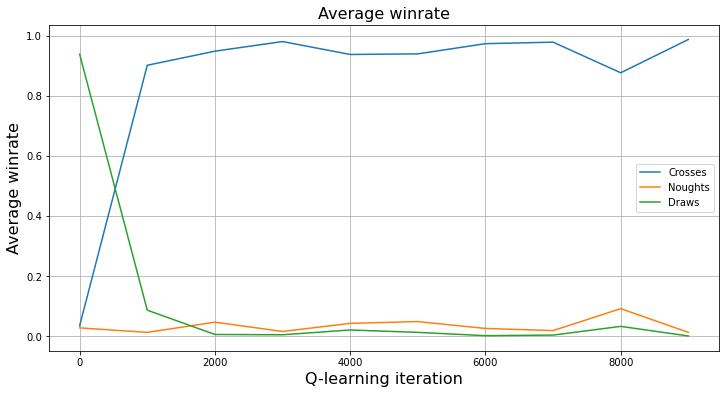

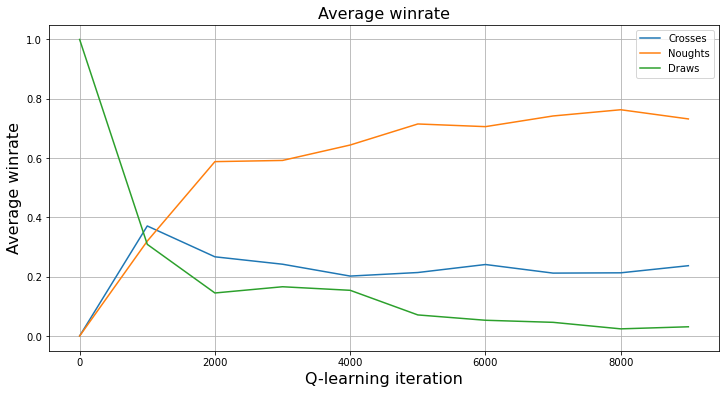

In [25]:
plot_history(scores_crosses_nn)
plot_history(scores_nought_nn)